In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [50]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

In [51]:
y = np.log(y)

## Simple network

In [91]:
df = df_full.drop(columns=['dist_to_station', 'degree', 'index', 'hour_index']+weather_var, inplace = False)
df

,index,leave_fuel,weekend,Time_Cos,Time_Sin,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,2019-08-15 00:00:00,30,0,1.000000,0.000364,6.618094,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-08-15 00:00:00,86,0,0.999999,0.001018,6.618094,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-08-15 00:00:00,4,0,0.999997,0.002327,6.618094,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-08-15 00:00:00,30,0,0.999968,0.007999,6.618094,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-08-15 00:00:00,32,0,0.999957,0.009236,6.618094,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,2019-12-19 00:00:00,94,0,0.999934,-0.011490,6.318741,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
326588,2019-12-19 00:00:00,59,0,0.999970,-0.007708,6.318741,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,2019-12-19 00:00:00,48,0,0.999980,-0.006327,6.318741,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,2019-12-19 00:00:00,23,0,0.999990,-0.004363,6.318741,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [93]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18273


In [94]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

In [95]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4084x271 and 268x64)

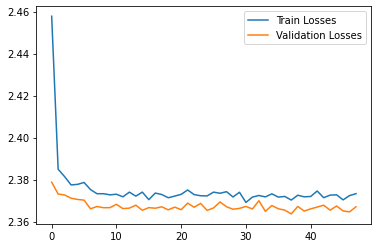

0.17219544185414537


In [ ]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

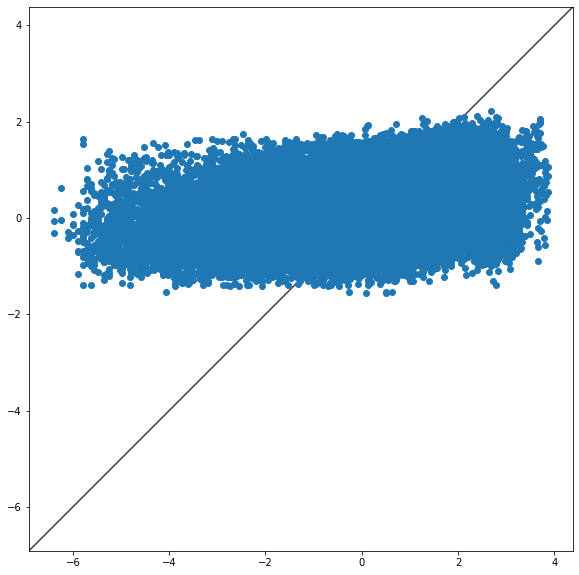

In [ ]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show() # Introduce alpha as transparancy

In [96]:
import shap

## No Zones

In [61]:
df = df_full.iloc[:,:11]
df.drop(columns = ['degree','index','hour_index'], inplace = True)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,30,0,1.000000,0.000364,0,0,1,0
1,86,0,0.999999,0.001018,0,0,1,0
2,4,0,0.999997,0.002327,1,0,0,0
3,30,0,0.999968,0.007999,0,0,1,0
4,32,0,0.999957,0.009236,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0
326588,59,0,0.999970,-0.007708,1,0,0,0
326589,48,0,0.999980,-0.006327,1,0,0,0
326590,23,0,0.999990,-0.004363,0,0,1,0


In [62]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [63]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.0),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.0),
            nn.Linear(128,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
) 35329


In [64]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.586809 , Valid Loss 2.521494 ,Train R2 0.110521, Valid R2 0.112395
Epoch 11: Train Loss 2.535625 , Valid Loss 2.512386 ,Train R2 0.113438, Valid R2 0.115601
Epoch 21: Train Loss 2.533574 , Valid Loss 2.510570 ,Train R2 0.114065, Valid R2 0.116241
Epoch 31: Train Loss 2.532693 , Valid Loss 2.510364 ,Train R2 0.114286, Valid R2 0.116313
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 40: Train Loss 2.532470 , Valid Loss 2.509272 , Train R2 0.114766, Valid R2 0.116698


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

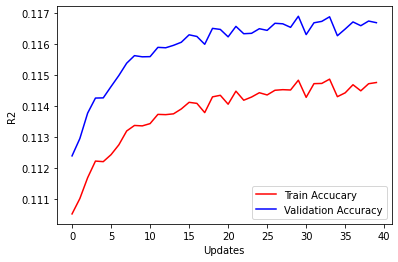

In [65]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

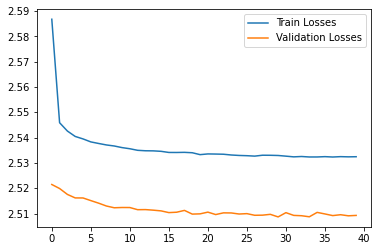

0.11892350092110282


In [66]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

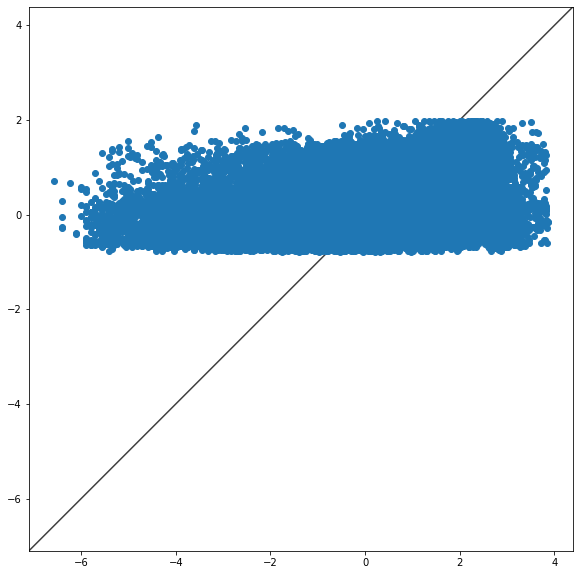

In [67]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [68]:
import shap

In [69]:
explainer = shap.Explainer(net)

In [72]:
X_test.detach().numpy()[1,:]

array([ 2.8811431e-01, -6.4720207e-01,  1.6919581e+00, -3.8013450e-04,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
      dtype=float32)

In [71]:
shap_values = explainer(X_test.detach().numpy()[1,:])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

## With embedding

In [19]:
df = df_full.drop(columns=['dist_to_station', 'degree']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,43,0,6.805269,0,0,1,0,209
1,86,0,6.805269,0,0,1,0,138
2,5,0,6.805269,1,0,0,0,56
3,30,0,6.805269,0,0,1,0,235
4,32,0,6.805269,0,1,0,0,75
...,...,...,...,...,...,...,...,...
326587,94,0,6.457874,0,0,1,0,63
326588,57,0,6.457874,1,0,0,0,45
326589,48,0,6.457874,1,0,0,0,75
326590,23,0,6.457874,0,0,1,0,148


In [20]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [21]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(7+emb_dim,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 3)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 3)
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 44816


In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.650977 , Valid Loss 2.495608 ,Train R2 0.119087, Valid R2 0.114168
Epoch 11: Train Loss 2.341798 , Valid Loss 2.307635 ,Train R2 0.191423, Valid R2 0.180890
Epoch 21: Train Loss 2.325981 , Valid Loss 2.298472 ,Train R2 0.196333, Valid R2 0.184143
Epoch 31: Train Loss 2.320359 , Valid Loss 2.295148 ,Train R2 0.197979, Valid R2 0.185323
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 2.317978 , Valid Loss 2.295664 ,Train R2 0.197732, Valid R2 0.185139
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 44: Train Loss 2.317652 , Valid Loss 2.294431 , Train R2 0.198549, Valid R2 0.185577


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

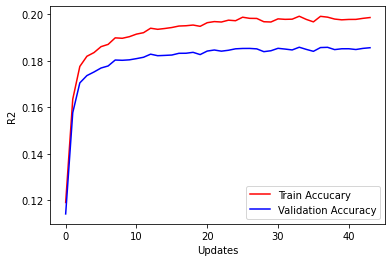

In [23]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

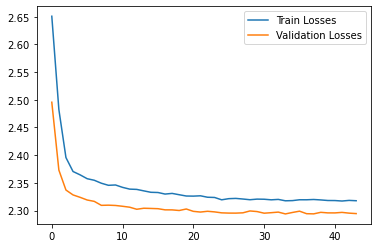

0.18847880781850768


In [24]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

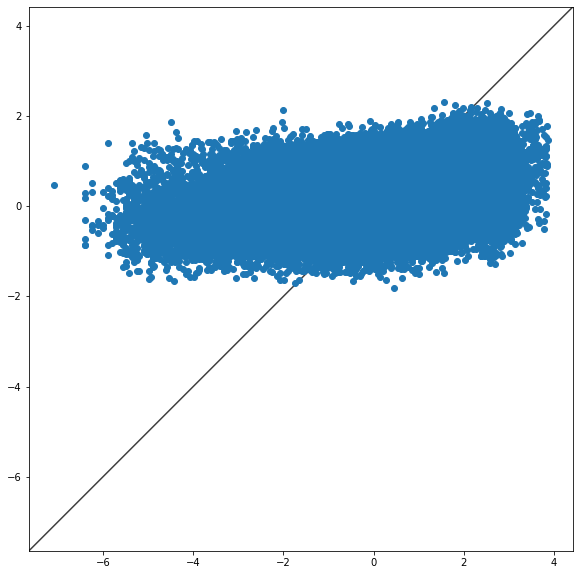

In [25]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With degree

In [26]:
df = df_full.drop(columns=['dist_to_station']+weather_var, inplace = False)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [28]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            #nn.Linear(64,64),
            #nn.ReLU(),#nn.BatchNorm1d(128)),
            #nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 42881


In [29]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.258486 , Valid Loss 2.177896 ,Train R2 0.251240, Valid R2 0.246353
Epoch 11: Train Loss 2.113238 , Valid Loss 2.137303 ,Train R2 0.272086, Valid R2 0.260400
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 2.110834 , Valid Loss 2.131896 ,Train R2 0.274807, Valid R2 0.262271
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 2.105956 , Valid Loss 2.132676 ,Train R2 0.275533, Valid R2 0.262001
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 2.105794 , Valid Loss 2.128712 ,Train R2 0.275623, Valid R2 0.263372
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 2.105313 , Valid Loss 2.130333 ,Train R2 0.276307, Valid R2 0.262812
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 53: Train Loss 2.106427 , Valid Loss 2.128733 , Train R2 0.276600, Valid R2 0.263365


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

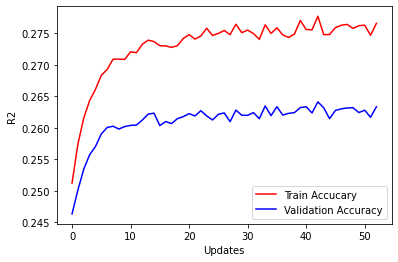

In [30]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

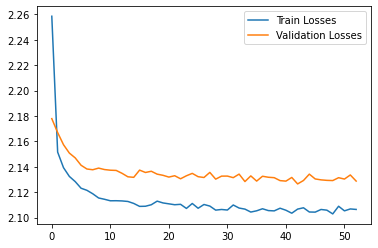

0.2635140839837613


In [31]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

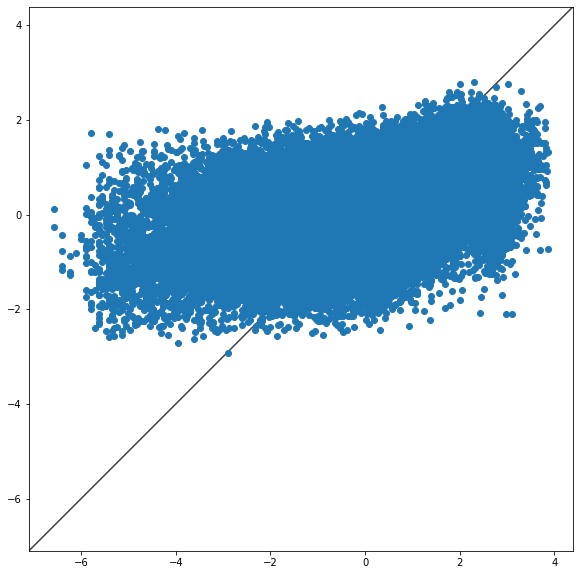

In [32]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [33]:
df = df_full.drop(columns=weather_var+['degree'], inplace = False)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,43,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,5,0,6.805269,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,57,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [34]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [35]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 25665


In [36]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.484655 , Valid Loss 2.346124 ,Train R2 0.183406, Valid R2 0.181308
Epoch 11: Train Loss 2.307812 , Valid Loss 2.303103 ,Train R2 0.207942, Valid R2 0.196320
Epoch 21: Train Loss 2.292121 , Valid Loss 2.296432 ,Train R2 0.213175, Valid R2 0.198648
Epoch 31: Train Loss 2.284185 , Valid Loss 2.298986 ,Train R2 0.215839, Valid R2 0.197757
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 2.282815 , Valid Loss 2.298471 ,Train R2 0.217425, Valid R2 0.197937
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 48: Train Loss 2.277284 , Valid Loss 2.296039 , Train R2 0.218709, Valid R2 0.198785


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

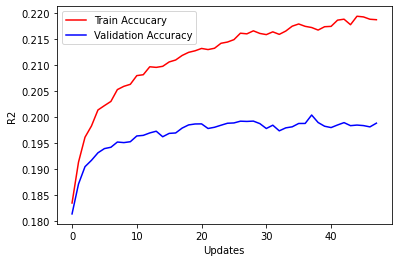

In [37]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

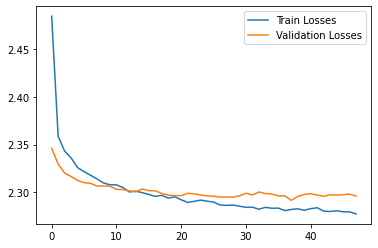

0.19732750597409998


In [38]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

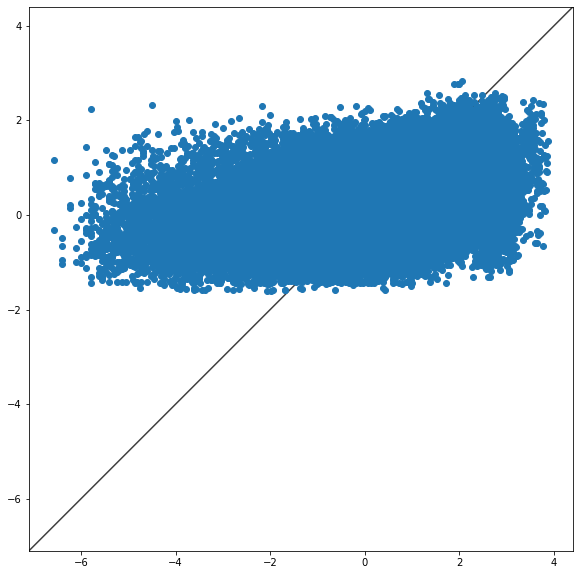

In [39]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With both

In [6]:
df = df_full.drop(columns=['index','hour_index']+weather_var, inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [7]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(271,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            #nn.Linear(128,64),
            #nn.ReLU(),#nn.BatchNorm1d(64)),
            #nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=271, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18465


In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.338950 , Valid Loss 2.127001 ,Train R2 0.263851, Valid R2 0.256213
Epoch 11: Train Loss 2.012670 , Valid Loss 2.018903 ,Train R2 0.315232, Valid R2 0.294014
Epoch 21: Train Loss 1.990199 , Valid Loss 2.012266 ,Train R2 0.321240, Valid R2 0.296335
Epoch 31: Train Loss 1.979297 , Valid Loss 2.011011 ,Train R2 0.324423, Valid R2 0.296773
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 1.973741 , Valid Loss 2.011626 ,Train R2 0.326809, Valid R2 0.296558
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 1.973601 , Valid Loss 2.009935 ,Train R2 0.327972, Valid R2 0.297150
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 54: Train Loss 1.971064 , Valid Loss 2.008639 , Train R2 0.329166, Valid R2 0.297603


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

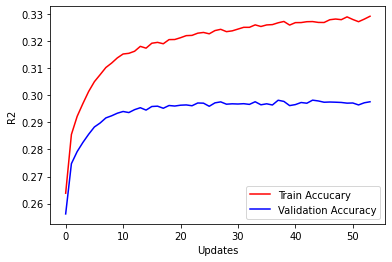

In [10]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

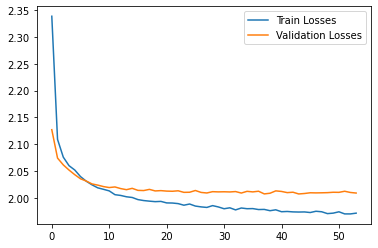

0.30186309276609635


In [11]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

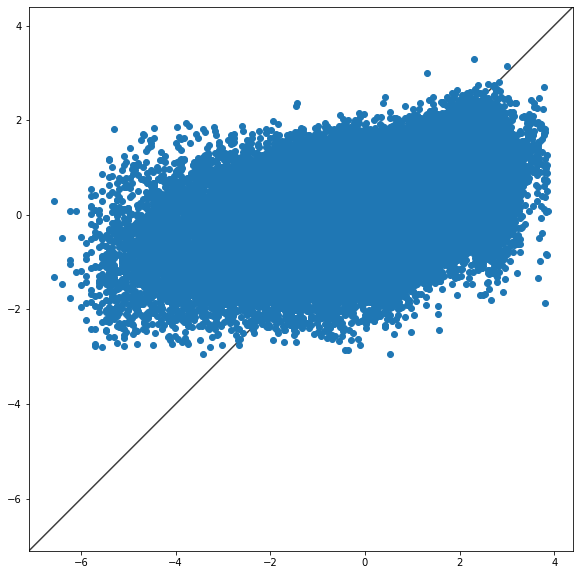

In [12]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [39]:
import shap

In [41]:
X,y = shap.datasets.adult()

In [44]:
train_data[:1000]

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,dist_to_station,eng_118I,eng_COOPER,eng_I3,eng_X1,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
319433,0.917926,0.061031,-0.649152,-0.775888,1.545025,1.345059,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
120536,1.340190,0.526192,-0.649152,-0.003653,-1.033749,-0.505193,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
196793,1.044605,-1.125244,-0.649152,-0.886893,1.432969,-0.954628,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
209621,-0.644450,-1.011626,-0.649152,0.648170,-0.998657,-0.974612,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97147,0.960152,-0.676384,1.540463,-0.685340,-0.737058,0.755983,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139172,-0.982261,-1.039267,-0.649152,0.449835,-1.039606,1.457558,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
36180,1.424642,0.088583,-0.649152,-0.127795,-1.008007,0.353288,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
220774,0.242304,2.214828,1.540463,1.193994,1.602315,-0.430214,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63215,1.424642,-0.642521,1.540463,-1.210775,0.840461,-0.596731,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
explainer = shap.Explainer(net, train_data[:1000])
shap_values = explainer(train_data[:1000], max_evals = 600)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
shap.plots.bar(shap_values)

In [25]:
e = shap.DeepExplainer(net, X_train[:10000,:])
shap_values = e.shap_values(X_test[:100,:])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [27]:
dict(zip(df.columns, shap_values.mean(axis = 0)))

{'leave_fuel': 0.038969031105370956,
 'degree': 0.06763129961997037,
 'weekend': 0.005984740089916158,
 'Time_Cos': 0.024678894043609033,
 'Time_Sin': -0.01685136589308968,
 'eng_118I': 0.07116909816395492,
 'eng_COOPER': 0.0035083330882480367,
 'eng_I3': 0.004918211660115048,
 'eng_X1': 0.0028941816883161662,
 'lz_102111': 0.0011849144636653364,
 'lz_102121': 0.00024732097119340324,
 'lz_102122': -0.01781805869657546,
 'lz_102131': 0.002067206391366199,
 'lz_102141': 0.0028629946178989484,
 'lz_102142': 0.007588949527125806,
 'lz_102151': 0.005509956259047612,
 'lz_102152': 0.002529779240721837,
 'lz_102161': 0.0020912277325987817,
 'lz_102162': -0.007667746206279844,
 'lz_102171': 0.003436298860324314,
 'lz_102172': -0.0004006693803239614,
 'lz_102181': 0.00043076694091723764,
 'lz_102182': 0.001152422762606875,
 'lz_102183': 0.003192415981320664,
 'lz_102184': 0.0021588329883525147,
 'lz_102211': -0.0069453975139185786,
 'lz_102212': 0.00031255931732744103,
 'lz_102213': 0.001320984

In [30]:
shap.plots.bar(shap_values[0])

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

## With weather

In [132]:
df = df_full.drop(df_full.filter(regex='Avg').columns,axis=1)
df.drop(columns = ['index', 'hour_index'],inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [133]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [134]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60545


In [135]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.211424 , Valid Loss 2.207847 ,Train R2 0.227317, Valid R2 0.223762
Epoch 11: Train Loss 1.972901 , Valid Loss 2.022007 ,Train R2 0.310658, Valid R2 0.289100
Epoch 21: Train Loss 1.928862 , Valid Loss 2.006524 ,Train R2 0.326046, Valid R2 0.294543
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 1.909876 , Valid Loss 2.003575 ,Train R2 0.332679, Valid R2 0.295580
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 1.898565 , Valid Loss 2.001997 ,Train R2 0.336631, Valid R2 0.296135
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 1.889768 , Valid Loss 1.995432 ,Train R2 0.339705, Valid R2 0.298443
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 1.882197 , Valid Loss 1.998576 ,Train R2 0.342351, Valid R2 0.297338
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 68: Train Loss 1.884456 , Valid Loss 2.003456 , Train R2 0.341561, Valid R2 0.295622


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

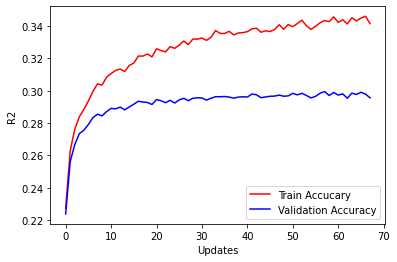

In [136]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

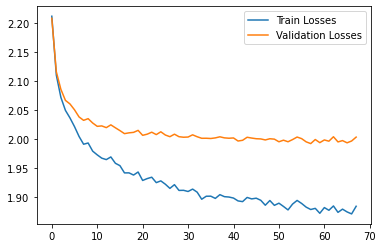

0.2990112262902923


In [137]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

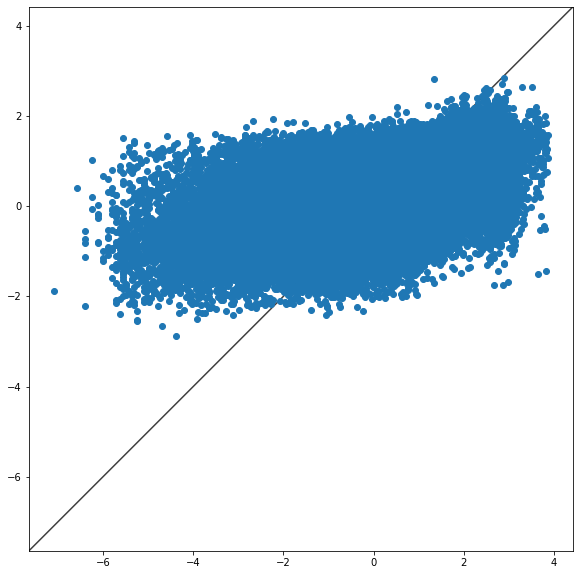

In [138]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [139]:
import shap

In [145]:
e = shap.DeepExplainer(net, X_train[:100,:])
shap_values = e.shap_values(X_test[:3,:])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


## Average weather (cheat)

In [59]:
df = df_full.drop(weather_var[:7]+weather_var[-7:],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [60]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [61]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.33),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.33, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.33, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 112385


In [62]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 1.972255 , Valid Loss 1.979385 ,Train R2 0.312386, Valid R2 0.305272
Epoch 11: Train Loss 1.557002 , Valid Loss 1.694597 ,Train R2 0.457161, Valid R2 0.405227
Epoch 21: Train Loss 1.408034 , Valid Loss 1.604742 ,Train R2 0.509098, Valid R2 0.436765
Epoch 31: Train Loss 1.337805 , Valid Loss 1.553075 ,Train R2 0.533583, Valid R2 0.454899
Epoch 41: Train Loss 1.287030 , Valid Loss 1.517186 ,Train R2 0.551285, Valid R2 0.467495
Epoch 51: Train Loss 1.238837 , Valid Loss 1.486488 ,Train R2 0.568087, Valid R2 0.478270
Epoch 61: Train Loss 1.218318 , Valid Loss 1.468990 ,Train R2 0.575241, Valid R2 0.484411
Epoch 71: Train Loss 1.205606 , Valid Loss 1.456271 ,Train R2 0.579673, Valid R2 0.488875
Epoch 81: Train Loss 1.179205 , Valid Loss 1.428604 ,Train R2 0.588878, Valid R2 0.498586
Epoch 91: Train Loss 1.171755 , Valid Loss 1.422377 ,Train R2 0.591475, Valid R2 0.500772
Epoch 101: Train Loss 1.159970 , Valid Loss 1.414785 ,Train R2 0.595584, Valid R2 0.503436
Epoch 111

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

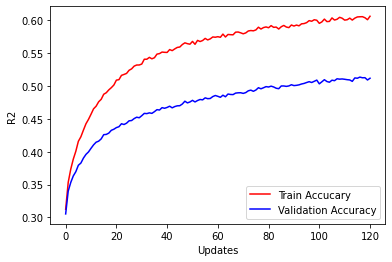

In [63]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

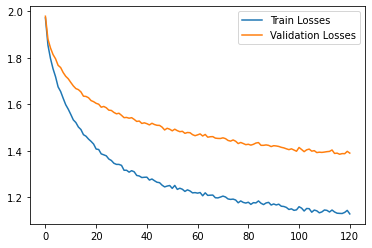

0.5151957916491444


In [64]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

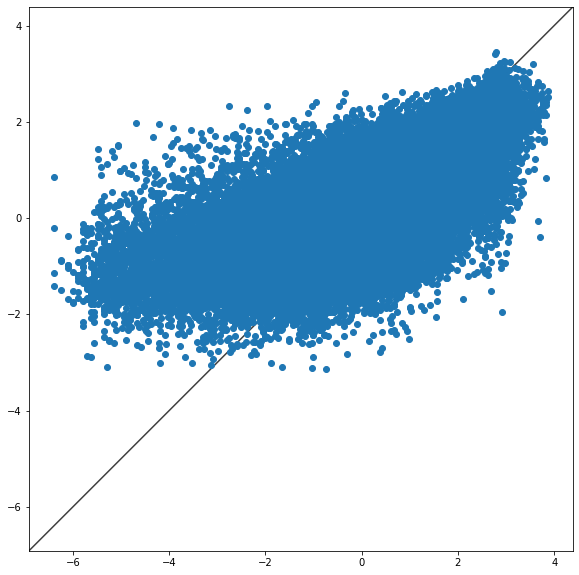

In [65]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Only average weather

In [33]:
df_w = df_full[weather_var[7:14]+['dist_to_station']]
df_w

,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...
326587,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [34]:
train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [35]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.25),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 43521


In [36]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.465452 , Valid Loss 2.460359 ,Train R2 0.137398, Valid R2 0.138243
Epoch 11: Train Loss 1.764917 , Valid Loss 1.770829 ,Train R2 0.382498, Valid R2 0.379755
Epoch 21: Train Loss 1.558495 , Valid Loss 1.577244 ,Train R2 0.454720, Valid R2 0.447560
Epoch 31: Train Loss 1.472719 , Valid Loss 1.490951 ,Train R2 0.484731, Valid R2 0.477784
Epoch 41: Train Loss 1.437864 , Valid Loss 1.458746 ,Train R2 0.496926, Valid R2 0.489064
Epoch 51: Train Loss 1.405427 , Valid Loss 1.425251 ,Train R2 0.508275, Valid R2 0.500796
Epoch 61: Train Loss 1.372360 , Valid Loss 1.398733 ,Train R2 0.519845, Valid R2 0.510084
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 1.352385 , Valid Loss 1.380458 ,Train R2 0.526833, Valid R2 0.516485
Epoch 81: Train Loss 1.330132 , Valid Loss 1.357381 ,Train R2 0.534619, Valid R2 0.524568
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 1.311791 , Valid Loss 1.331768 ,Train R2 0.541036, Valid R2 0.533539
Epoch 101: Train Loss 1.307834

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

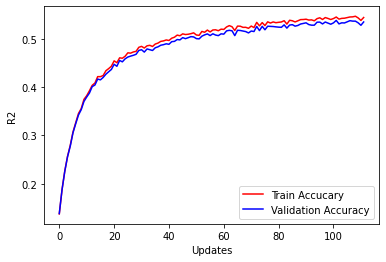

In [37]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

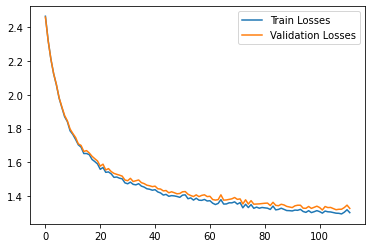

0.5348514886070226


In [38]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

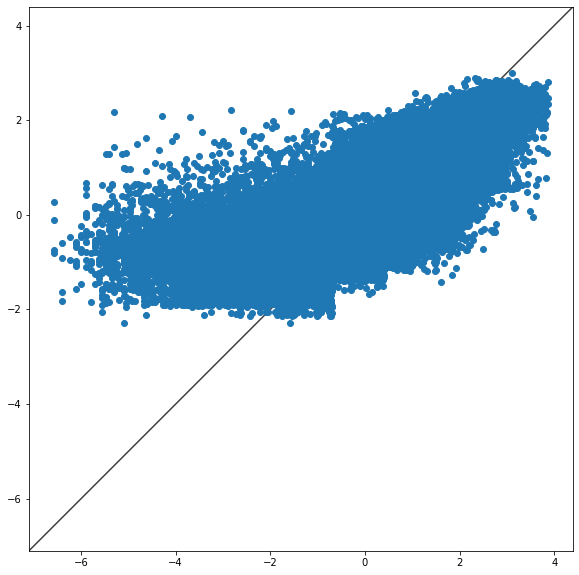

In [39]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

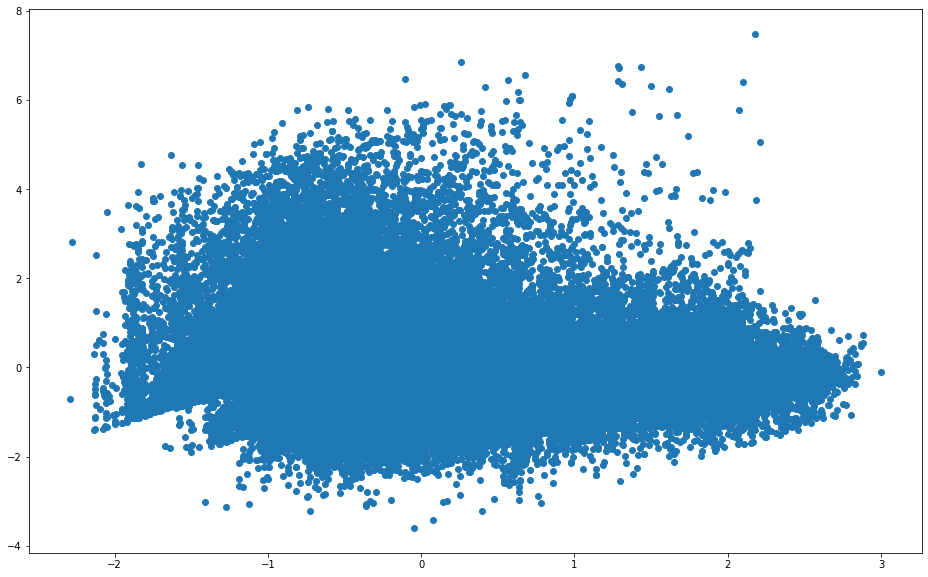

In [40]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])
plt.show()

In [41]:
np.corrcoef(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

array([[ 1.        , -0.16758657],
       [-0.16758657,  1.        ]])

In [42]:
np.mean(net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

0.07333828

## With weather (index)

In [73]:
df = df_full.drop(weather_var[:14],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500
326588,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658
326589,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913
326590,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805


In [74]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [75]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26177


In [76]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0004) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.209445 , Valid Loss 2.210053 ,Train R2 0.226895, Valid R2 0.225771
Epoch 11: Train Loss 2.055360 , Valid Loss 2.095102 ,Train R2 0.280811, Valid R2 0.266040
Epoch 21: Train Loss 2.035296 , Valid Loss 2.086599 ,Train R2 0.287831, Valid R2 0.269019
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 2.021920 , Valid Loss 2.083114 ,Train R2 0.292512, Valid R2 0.270240
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 35: Train Loss 2.015995 , Valid Loss 2.081627 , Train R2 0.294585, Valid R2 0.270761


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

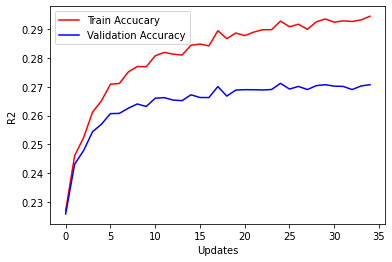

In [77]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

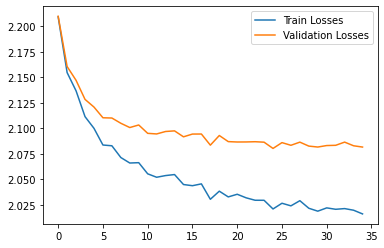

0.27556001054059265


In [78]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

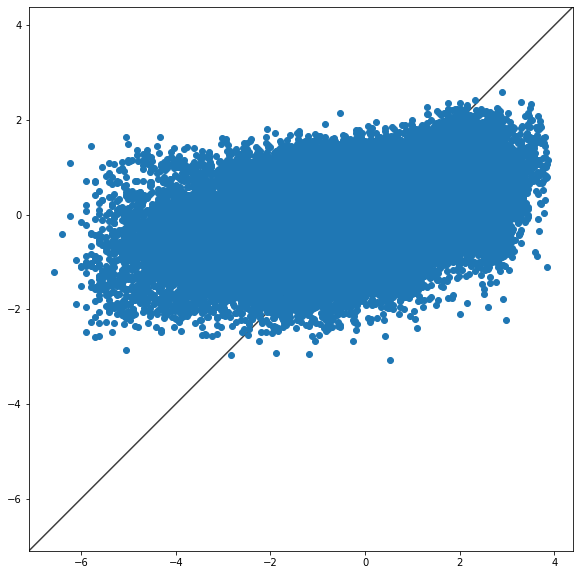

In [79]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather and embedding

In [52]:
df = df_full.drop(df_full.filter(regex='Avg').columns,axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df = df.drop(columns = ['hour_index', 'index'])
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080,209
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483,138
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741,56
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806,235
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500,63
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658,45
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913,75
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805,148


In [53]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [54]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [55]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.351287 , Valid Loss 2.353685 ,Train R2 0.178580, Valid R2 0.176568
Epoch 11: Train Loss 1.995277 , Valid Loss 2.021360 ,Train R2 0.302952, Valid R2 0.292831
Epoch 21: Train Loss 1.972778 , Valid Loss 2.006916 ,Train R2 0.310812, Valid R2 0.297884
Epoch 31: Train Loss 1.959167 , Valid Loss 1.998516 ,Train R2 0.315567, Valid R2 0.300823
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 1.955233 , Valid Loss 1.995625 ,Train R2 0.316941, Valid R2 0.301834
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 1.949579 , Valid Loss 1.994114 ,Train R2 0.318916, Valid R2 0.302363
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 1.945568 , Valid Loss 1.995868 ,Train R2 0.320318, Valid R2 0.301749
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 64: Train Loss 1.944808 , Valid Loss 1.991821 , Train R2 0.320583, Valid R2 0.303165


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

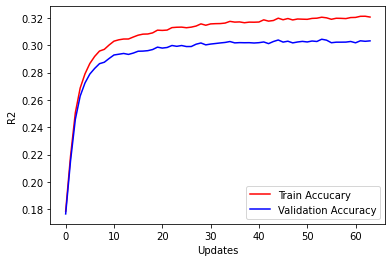

In [56]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

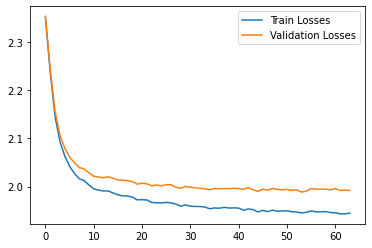

0.3016306923669938
0.09946949727477739


In [57]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))
print(r2_score(np.exp(y_test.detach().numpy()[:,0]),np.exp(net.forward(X_test).detach().numpy()[:,0])))

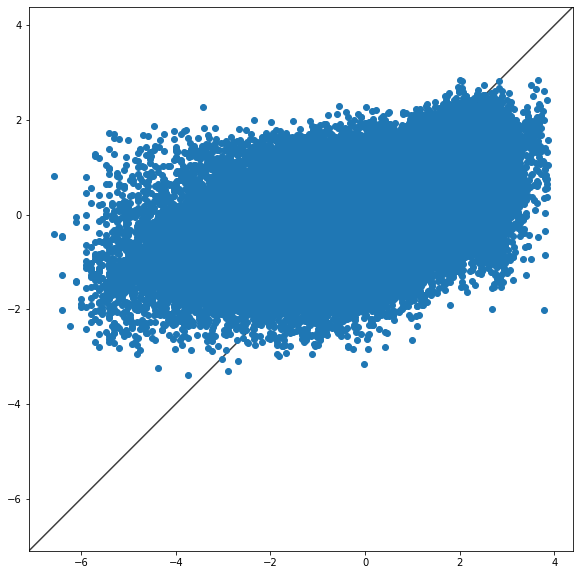

In [58]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [18]:
import shap

In [29]:
X_test.detach().numpy()[:50,:]

array([[-4.91192564e-02, -7.65317321e-01, -6.50060594e-01,
         6.96732640e-01, -9.83230710e-01,  1.30091295e-01,
        -1.50548980e-01, -2.56495744e-01,  1.68751419e+00,
         8.78809810e-01, -1.06051373e+00, -1.51105225e+00,
         3.43055189e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.22000000e+02],
       [ 1.25905943e+00,  7.02460885e-01, -6.50060594e-01,
        -1.20807552e+00,  8.56025279e-01,  3.10918063e-01,
         2.66036749e-01, -6.09452464e-02, -5.27833879e-01,
        -1.89622641e+00,  1.01740050e+00,  6.54201925e-01,
        -7.70676076e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  8.00000000e+00],
       [-1.06190276e+00,  1.06554449e+00, -6.50060594e-01,
        -1.26460040e+00,  5.27915418e-01, -5.93215764e-01,
         1.61994040e+00,  1.34605259e-01, -5.38308322e-01,
        -1.05207205e+00,  1.12050319e+00,  9.15075958e-01,
         6.38131723e-02,  1.00000000e+00,  0.00000000e

In [31]:
explainer = shap.Explainer(net)

In [33]:
X_test.detach().numpy()[:50,:]

array([[-4.91192564e-02, -7.65317321e-01, -6.50060594e-01,
         6.96732640e-01, -9.83230710e-01,  1.30091295e-01,
        -1.50548980e-01, -2.56495744e-01,  1.68751419e+00,
         8.78809810e-01, -1.06051373e+00, -1.51105225e+00,
         3.43055189e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.22000000e+02],
       [ 1.25905943e+00,  7.02460885e-01, -6.50060594e-01,
        -1.20807552e+00,  8.56025279e-01,  3.10918063e-01,
         2.66036749e-01, -6.09452464e-02, -5.27833879e-01,
        -1.89622641e+00,  1.01740050e+00,  6.54201925e-01,
        -7.70676076e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  8.00000000e+00],
       [-1.06190276e+00,  1.06554449e+00, -6.50060594e-01,
        -1.26460040e+00,  5.27915418e-01, -5.93215764e-01,
         1.61994040e+00,  1.34605259e-01, -5.38308322e-01,
        -1.05207205e+00,  1.12050319e+00,  9.15075958e-01,
         6.38131723e-02,  1.00000000e+00,  0.00000000e

In [34]:
shap_values = explainer(X_test.detach().numpy()[1,:])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [36]:
X_test.detach().numpy()[1,:]

array([ 1.2590594 ,  0.7024609 , -0.6500606 , -1.2080755 ,  0.8560253 ,
        0.31091806,  0.26603675, -0.06094525, -0.5278339 , -1.8962264 ,
        1.0174005 ,  0.6542019 , -0.7706761 ,  0.        ,  0.        ,
        1.        ,  0.        ,  8.        ], dtype=float32)

## With average weather and embedding

In [43]:
df = df_full.drop(weather_var[:14],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df = df.drop(columns = ['hour_index', 'index'])
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080,209
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483,138
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806,235
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500,63
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658,45
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913,75
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805,148


In [44]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [48]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [49]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.311064 , Valid Loss 2.305424 ,Train R2 0.192132, Valid R2 0.192359
Epoch 11: Train Loss 1.994285 , Valid Loss 2.007999 ,Train R2 0.302867, Valid R2 0.296554
Epoch 21: Train Loss 1.966503 , Valid Loss 1.983111 ,Train R2 0.312579, Valid R2 0.305272
Epoch 31: Train Loss 1.957853 , Valid Loss 1.983127 ,Train R2 0.315603, Valid R2 0.305267
Epoch 41: Train Loss 1.949845 , Valid Loss 1.980666 ,Train R2 0.318402, Valid R2 0.306129
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 1.948337 , Valid Loss 1.983647 ,Train R2 0.318929, Valid R2 0.305085
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 52: Train Loss 1.945418 , Valid Loss 1.980683 , Train R2 0.319950, Valid R2 0.306123


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

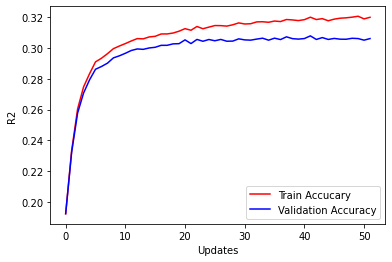

In [50]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

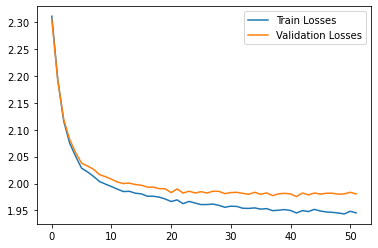

0.29552445681311756


In [51]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

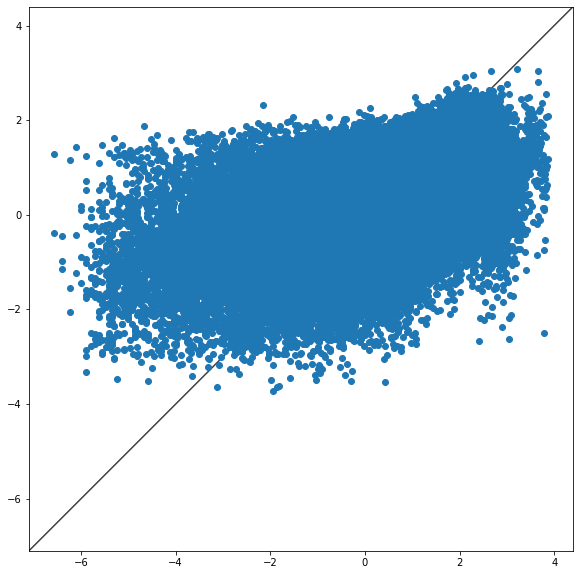

In [54]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

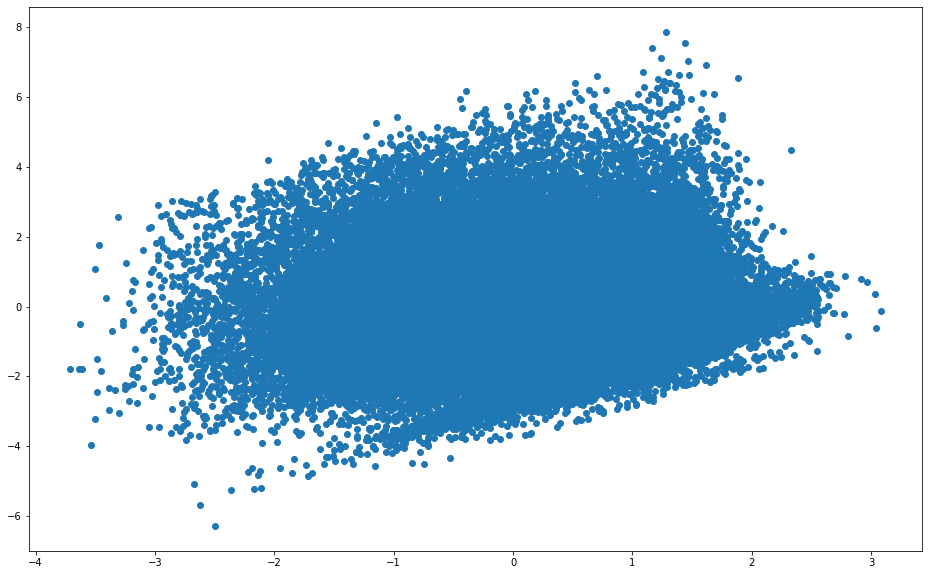

In [55]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])
plt.show()

In [56]:
np.corrcoef(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

array([[1.        , 0.05965501],
       [0.05965501, 1.        ]])

In [57]:
np.mean(net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

-0.044028603

## Embedding and cheating with weather

In [87]:
df = df_full.drop(weather_var[:7]+weather_var[-7:],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station,Zone
0,43,12.529378,0,6.805269,0,0,1,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080,209
1,86,14.027280,0,6.805269,0,0,1,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483,138
2,5,17.751882,0,6.805269,1,0,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,6.805269,0,0,1,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806,235
4,32,13.214864,0,6.805269,0,1,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,6.457874,0,0,1,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500,63
326588,57,14.221806,0,6.457874,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658,45
326589,48,16.451925,0,6.457874,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913,75
326590,23,15.140361,0,6.457874,0,0,1,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805,148


In [88]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [89]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(16+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30121


In [90]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 2.238930 , Valid Loss 2.235187 ,Train R2 0.217382, Valid R2 0.216125
Epoch 11: Train Loss 1.621737 , Valid Loss 1.641068 ,Train R2 0.433122, Valid R2 0.424481
Epoch 21: Train Loss 1.463709 , Valid Loss 1.493018 ,Train R2 0.488360, Valid R2 0.476402
Epoch 31: Train Loss 1.394070 , Valid Loss 1.425277 ,Train R2 0.512703, Valid R2 0.500159
Epoch 41: Train Loss 1.346764 , Valid Loss 1.381052 ,Train R2 0.529238, Valid R2 0.515668
Epoch 51: Train Loss 1.330538 , Valid Loss 1.369609 ,Train R2 0.534910, Valid R2 0.519681
Epoch 61: Train Loss 1.309972 , Valid Loss 1.347544 ,Train R2 0.542099, Valid R2 0.527419
Epoch 71: Train Loss 1.288436 , Valid Loss 1.331002 ,Train R2 0.549627, Valid R2 0.533221
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 1.281051 , Valid Loss 1.320140 ,Train R2 0.552208, Valid R2 0.537030
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 1.264782 , Valid Loss 1.308572 ,Train R2 0.557895, Valid R2 0.541087
EarlyStopping counter: 5 out o

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

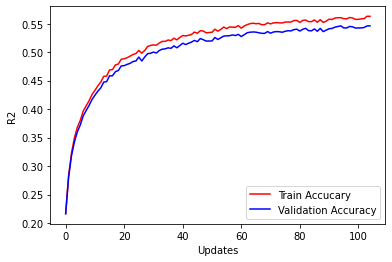

In [91]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

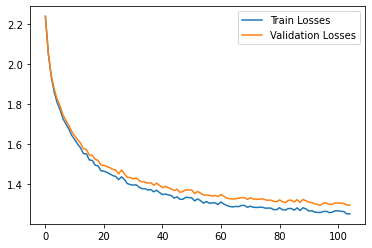

0.5406949696483145


In [92]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

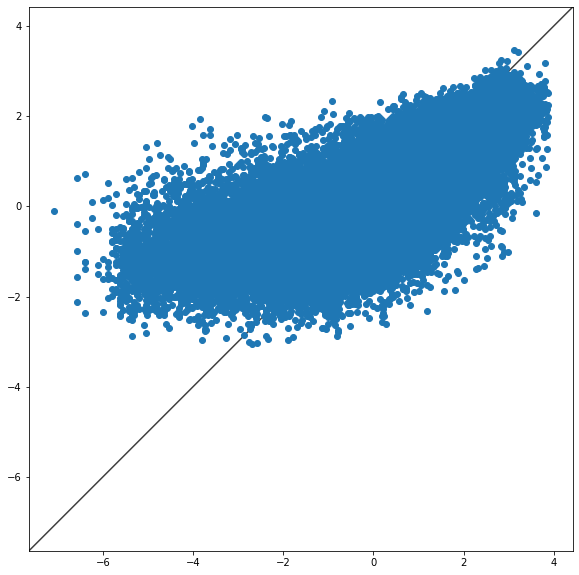

In [93]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()